In [1]:
import numpy as np
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')
import yaml
from operator import itemgetter
import pandas as pd
import os
from matplotlib import rc
rc('text', usetex=True)
from matplotlib.path import Path
from matplotlib.patches import PathPatch
from scipy import interpolate


import figures, growth


# Effect of supercooling on compaction

[A] Final average porosity for compaction lengths of $R_\text{ic}$, $0.1\,R_\text{ic}$ and $0.01\,R_\text{ic}$, as function of the supercooling time and the growth rate at the end of the run. The white lines emphasize the isosurface of average porosity, also shown in color, while the black lines are the isovalues of $<\phi>-<\phi_0>$, the difference between the observed final value of the run  $<\phi>$ and the final value without supercooling $<\phi_0>$. 

[B 1-6] Time evolution of the porosity for the 6 different runs highlighted in the panel [A] with the white $\star$ symbol. Each columns () correspond to the same set-up of compaction length and final growth rate, and a start time for supercooling of 0.3$\tau_\text{ic}$ and 0.6$\tau_\text{ic}$

In [2]:
## General functions to extract info from the statistics file:


def select_unique(dataframe):
    values = dataframe.unique()
    keep_values = np.abs(np.diff(values))>error
    keep_values = np.insert(keep_values,0,True)
    return values[keep_values]


def add_value(df, ric, coeff, exp, phi, delta, r0_supercooling, tau_ic):
    df_add = pd.DataFrame({"Ric_adim":[ric], "coeff_velocity":[coeff], "exp":[exp], 
                           "sum_phi":[phi], "delta":[delta], 
                           "r0_supercooling":[r0_supercooling], 
                           "tau_ic":[tau_ic]})
    df = df.append(df_add, ignore_index=True)
    return df

def extract_values(folder):
    
    list_subfolder = os.listdir(folder)
    print("Looking through folder {}".format(folder))

    columns = ["Ric_adim", "coeff_velocity", "exp", "sum_phi", "delta", "r0_supercooling", "tau_ic"]
    df = pd.DataFrame(columns=columns)

    for subfolder_name in list_subfolder:
                if os.path.isdir(folder + "/" + subfolder_name):
                
                    file_stat, param, timesteps = figures.extract_files(folder+"/"+subfolder_name)
                    #list_files = os.listdir(folder+"/"+subfolder_name)
                    #for file in list_files:
                    #    if file[-14:] == "statistics.txt":
                    #        file_stat = folder + "/" + subfolder_name + "/" + file
                    #    if file[-5:] == ".yaml":
                    #        with open(folder + "/" + subfolder_name + "/" + file, 'r') as stream:
                    #            try:
                    #                param = yaml.safe_load(stream)
                    #                #print(param)
                    #            except yaml.YAMLError as exc:
                    #                print(exc)
                    
                    data = pd.read_csv(file_stat, sep=" ", index_col=False)
                    
                    if data["thickness_boundary"].iloc[-1] < 1e-12:
                        pass #print("no boundary for {}, {}".format(param["Ric_adim"], param['coeff_velocity']))
                    try: 
                        supercooling = param["r0_supercooling"]
                        tic = param["tic"]
                    except: 
                        supercooling = 0.
                        tic = param["time_max"]

                    if data["radius"].iloc[-1] < 0.99*param["Ric_adim"]:
                        remarks = "run ended before completion. Radius {}/{}".format(data["radius"], param["Ric_adim"])
                    else:
                        remarks = ""
                        df = add_value(df, param["Ric_adim"], param['coeff_velocity'], param['growth_rate_exponent'], 
                                data["sum_phi"].iloc[-1], data["thickness_boundary"].iloc[-1], 
                                   supercooling, tic)
                    remarks=remarks+subfolder_name
                else: print("oups, not a folder: {}".format(folder + "/" + subfolder_name))
    df["r_dot"] = df["Ric_adim"]/df["tau_ic"]*df["exp"]
    df = df.sort_values(by=["Ric_adim", 'r_dot', "sum_phi"]).reset_index(drop=True)
    return df

## Extraction of the data from the appropriate folder: 

In [3]:
df_200 = extract_values("/home/lasbleis-m/Research/output_mush/supercooling_R_200/")
df_all = extract_values(folder = "/home/lasbleis-m/Research/output_mush/supercooling_diagram/")

df = pd.concat([df_200, df_all])

# df.to_csv("supercooling.csv", index=False)

Looking through folder /home/lasbleis-m/Research/output_mush/supercooling_R_200/
oups, not a folder: /home/lasbleis-m/Research/output_mush/supercooling_R_200//data.csv
Looking through folder /home/lasbleis-m/Research/output_mush/supercooling_diagram/
oups, not a folder: /home/lasbleis-m/Research/output_mush/supercooling_diagram//data.csv


[-2.5] 0.0
[-2.] 0.0
[-1.7] 0.4
[-1.5] 0.0
[-1.2] 0.4
[-1.] 0.0
[-0.7] 0.0
[-0.5] 0.0
[-0.3] 0.0
[-0.2] 0.0
[0.] 0.0
[0.2] 0.0
[0.3] 0.0
[0.5] 0.0
[0.7] 0.0
[1.] 0.0
[1.5] 0.0
[2.] 0.0
[-1.15] 0.5
[-1.35] 0.5
0.00024036 1.7989255465486373


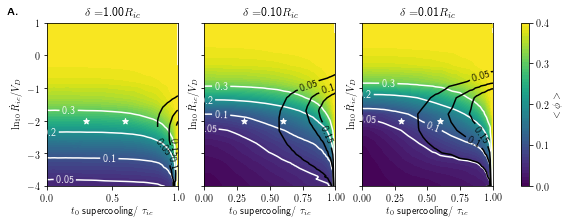

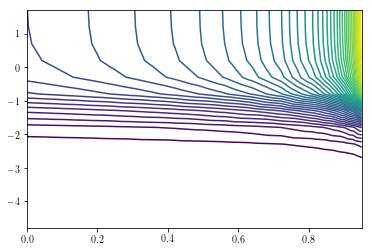

In [6]:
error=1e-12

radii = [1., 10., 100.]#select_unique(df["Ric_adim"])

fig2, ax2 = plt.subplots(1, len(radii),figsize=[10, 3], sharey=True)


for i_fig, radius in enumerate(radii):
    values = df[np.abs(df["Ric_adim"]-radius)<error]
    values = values.dropna()
    r_dot = select_unique(values["r_dot"])
    min_phi = np.zeros_like(r_dot)
    
    for i, growth_rate in enumerate(r_dot): 
        values_dot = values[np.abs(values["r_dot"]-growth_rate)<error]
        min_phi[i] = min(values_dot["sum_phi"])
        values.loc[np.abs(values["r_dot"]-growth_rate)<error, "min_phi"] = min_phi[i]
        if i_fig==1: print(np.log10(select_unique(values_dot["coeff_velocity"])), 
                                         min(select_unique(values_dot["r0_supercooling"])))

    #sc_fig2 = ax[i_fig].scatter((values["r0_supercooling"]/values["Ric_adim"])**2, np.log10(values['r_dot']), c=values["phi_r"],  cmap=plt.cm.get_cmap("viridis"))
    sc_fig2 = ax2[i_fig].tricontourf((values["r0_supercooling"]/values["Ric_adim"])**2, 
                                     np.log10(values['r_dot']), values["sum_phi"], levels=50, vmin=0, vmax=0.4, 
                                     cmap=plt.cm.get_cmap("viridis"))

    sc2_fig2 = ax2[i_fig].tricontour((values["r0_supercooling"]/values["Ric_adim"])**2, 
                                     np.log10(values['r_dot']), values["sum_phi"], levels=[0.05, 0.1, 0.2, 0.3, 0.4], 
                                     colors="w")

    fmt = {}
    strs = ["0.05", "0.1", "0.2", "0.3", "0.4"]
    for l, s in zip(sc2_fig2.levels, strs):
        fmt[l] = s
    ax2[i_fig].clabel(sc2_fig2, sc2_fig2.levels[::], fmt=fmt, fontsize=10, inline=True)

    sc3_fig2 = ax2[i_fig].tricontour((values["r0_supercooling"]/values["Ric_adim"])**2, 
                                     np.log10(values['r_dot']), values["sum_phi"]-values["min_phi"], 
                                     levels=[0.05, 0.1, 0.15], colors="k")
    
    
    values = values[values["r0_supercooling"]/values["Ric_adim"]<0.98]
    theoritical = (1-(values["r0_supercooling"]/values["Ric_adim"])**2)**(-0.5)*values["min_phi"]
    #sc4 = ax2[i_fig].tricontour((values["r0_supercooling"]/values["Ric_adim"])**2, np.log10(values['r_dot']), theoritical, levels=10)

    

        
    fmt = {}
    strs = ["0.05", "0.1", "0.15"]
    for l, s in zip(sc3_fig2.levels, strs):
        fmt[l] = s

    
    ax2[i_fig].clabel(sc3_fig2, sc3_fig2.levels[::], fmt=fmt, fontsize=10, inline=True)
    ax2[i_fig].set_ylim([-4,1])
    ax2[i_fig].set_ylim([-4,1])
    ax2[i_fig].set_ylabel(r"$\ln_{{10}} \dot R_{ic}/V_D$")
    ax2[i_fig].set_xlabel(r"$t_0$ supercooling/ $\tau_{ic}$")
    ax2[i_fig].set_title(r"$\delta=${:.2f}$ R_{{ic}}$".format(1/radius))
    
    
    time = [0.3, 0.6]
    dot_R = -2*np.ones_like(time)
    ax2[i_fig].scatter(time, dot_R, c="w", marker="*")
    
    
ax2[0].text(-0.3, 1.10, r"\textbf{A.}", transform=ax2[0].transAxes, fontsize=11,
            verticalalignment='top')


cbar2 = fig2.colorbar(sc_fig2, ax=ax2.ravel().tolist(), ticks=[0., 0.1, 0.2, 0.3, 0.4])
cbar2.ax.set_ylabel("$<\phi>$")

plt.savefig("fig/supercooling_time.pdf", transparent=True, bbox_inches="tight")


values = values[values["r0_supercooling"]/values["Ric_adim"]<0.98]

theoritical = (1-(values["r0_supercooling"]/values["Ric_adim"])**2)**(-0.5)*values["min_phi"]

print(min(theoritical), max(theoritical))
fig, ax = plt.subplots()
sc4 = ax.tricontour((values["r0_supercooling"]/values["Ric_adim"])**2, np.log10(values['r_dot']), theoritical, levels=50)

# 
    

Text(0, 0.5, '$<\\phi>$')

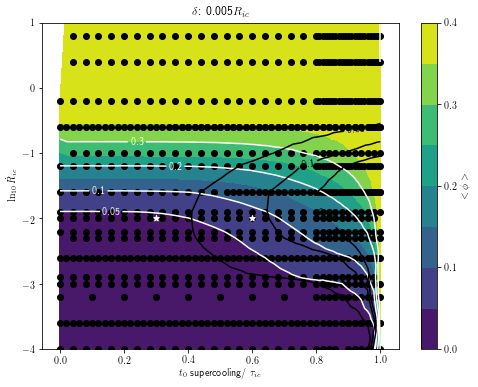

In [4]:
import sys
np.set_printoptions(threshold=sys.maxsize) 
error=1e-12

radius = 200.#select_unique(df["Ric_adim"])

fig2, ax2 = plt.subplots(figsize=[8, 6])



values = df[np.abs(df["Ric_adim"]-radius)<error]
values = values.dropna()
r_dot = select_unique(values["r_dot"])
min_phi = np.zeros_like(r_dot)
    
for i, growth_rate in enumerate(r_dot): 
        values_dot = values[np.abs(values["r_dot"]-growth_rate)<error]
        min_phi[i] = min(values_dot["sum_phi"])
        values.loc[np.abs(values["r_dot"]-growth_rate)<error, "min_phi"] = min_phi[i]
        #if i_fig==1: print(np.log10(select_unique(values_dot["coeff_velocity"])), 
        #                                 min(select_unique(values_dot["r0_supercooling"])))

    #sc_fig2 = ax[i_fig].scatter((values["r0_supercooling"]/values["Ric_adim"])**2, np.log10(values['r_dot']), c=values["phi_r"],  cmap=plt.cm.get_cmap("viridis"))
sc_fig2 = ax2.tricontourf((values["r0_supercooling"]/values["Ric_adim"]), np.log10(values['r_dot']), values["sum_phi"]) #, levels=50, vmin=0, vmax=0.4, cmap=plt.cm.get_cmap("viridis"))

sc2_fig2 = ax2.tricontour((values["r0_supercooling"]/values["Ric_adim"]), np.log10(values['r_dot']), values["sum_phi"], levels=[0.05, 0.1, 0.2, 0.3, 0.4], colors="w")

ax2.scatter((values["r0_supercooling"]/values["Ric_adim"]), np.log10(values['r_dot']), c='k')

#print(values["sum_phi"].tolist)
fmt = {}
strs = ["0.05", "0.1", "0.2", "0.3", "0.4"]
for l, s in zip(sc2_fig2.levels, strs):
        fmt[l] = s
ax2.clabel(sc2_fig2, sc2_fig2.levels[::], fmt=fmt, fontsize=10, inline=True)

sc3_fig2 = ax2.tricontour((values["r0_supercooling"]/values["Ric_adim"])**2, np.log10(values['r_dot']), values["sum_phi"]-values["min_phi"], levels=[0.05, 0.1, 0.15], colors="k")
    
    
values = values[values["r0_supercooling"]/values["Ric_adim"]<0.98]
#theoritical = (1-(values["r0_supercooling"]/values["Ric_adim"])**2)**(-0.5)*values["min_phi"]
    #sc4 = ax2[i_fig].tricontour((values["r0_supercooling"]/values["Ric_adim"])**2, np.log10(values['r_dot']), theoritical, levels=10)

    

        
fmt = {}
strs = ["0.05", "0.1", "0.15"]
for l, s in zip(sc3_fig2.levels, strs):
    fmt[l] = s

    
ax2.clabel(sc3_fig2, sc3_fig2.levels[::], fmt=fmt, fontsize=10, inline=True)
ax2.set_ylim([-4,1])
ax2.set_ylim([-4,1])
ax2.set_ylabel(r"$\ln_{{10}} \dot R_{ic}$")
ax2.set_xlabel(r"$t_0$ supercooling/ $\tau_{ic}$")
ax2.set_title(r"$\delta$: {:.3f}$R_{{ic}}$".format(1./radius))

    
time = [0.3, 0.6]
dot_R = -2*np.ones_like(time)
ax2.scatter(time, dot_R, c="w", marker="*")
    
    
#ax2.text(-0.3, 1.10, r"\textbf{A.}", transform=ax2[0].transAxes, fontsize=11,
#            verticalalignment='top')


cbar2 = fig2.colorbar(sc_fig2, ax=ax2, ticks=[0., 0.1, 0.2, 0.3, 0.4])
cbar2.ax.set_ylabel("$<\phi>$")


# Time evolution

Looking through folder /home/lasbleis-m/Research/output_mush/supercooling_three/
0 0
0 1
0 2
1 0
1 1
1 2


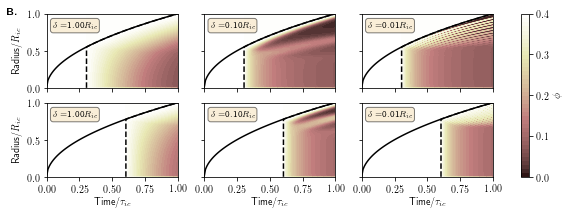

In [8]:
folder_main = "/home/lasbleis-m/Research/output_mush/supercooling_three/"



print("Looking through folder {}".format(folder_main))

list_subfolder_R1 = ["/home/lasbleis-m/Research/output_mush/supercooling_three/exp_5.00e-01_coeff_1.41e-01_radius_1.00e+00_r0_54.77225575051661",
                     "/home/lasbleis-m/Research/output_mush/supercooling_three/exp_5.00e-01_coeff_1.41e-01_radius_1.00e+00_r0_77.45966692414834"]

list_subfolder_R10 = ["/home/lasbleis-m/Research/output_mush/supercooling_three/exp_5.00e-01_coeff_4.47e-01_radius_1.00e+01_r0_54.77225575051661",
                     "/home/lasbleis-m/Research/output_mush/supercooling_three/exp_5.00e-01_coeff_4.47e-01_radius_1.00e+01_r0_77.45966692414834"]
    
list_subfolder_R100 = ["/home/lasbleis-m/Research/output_mush/supercooling_three/exp_5.00e-01_coeff_1.41e+00_radius_1.00e+02_r0_54.77225575051661",
                      "/home/lasbleis-m/Research/output_mush/supercooling_three/exp_5.00e-01_coeff_1.41e+00_radius_1.00e+02_r0_77.45966692414834"]

    
import operator

fig, ax =plt.subplots(2, 3, figsize=[10, 3], sharex=True, sharey=True)

for i_f, folder_R1 in enumerate(list_subfolder_R1):
    #fig, ax = plt.subplots()
    
    for j_f, folder in enumerate([folder_R1, list_subfolder_R10[i_f], list_subfolder_R100[i_f]]):
        file_stat, param, timesteps = figures.extract_files(folder)
        name_max = max(timesteps.items(), key=itemgetter(1))[0]
        data = pd.read_csv(name_max, sep=" ")
        dr = data["radius"][1]-data["radius"][0]
        Radius = np.array(data["radius"].values)+ dr / 2.
        #print(Radius)
        try: 
            supercooling = param["Dt_supercooling"]
            param["dot_r"] = param["Ric_adim"]/param["tic"]*param["growth_rate_exponent"]
        except: 
            supercooling = 0.
            param["dot_r"] = param["Ric_adim"]/param["time_max"]*param["growth_rate_exponent"]

        Time = supercooling+ np.array(sorted(timesteps.values()))
        
        #Time = Time/param["time_max"]
        #Radius = Radius/param["Ric_adim"]
        
        rayon = np.zeros_like(Time)
        #print((Time))
        X, Y = np.meshgrid(Time, Radius)
        Z = 0.4*np.ones_like(X)
        #print(timesteps)
        for i, (name, time) in enumerate(sorted(timesteps.items(), key = itemgetter(1))):
            data = pd.read_csv(name, sep=" ")
            #Porosity = np.array(data["porosity"].values)
            #N_r = len(Porosity)
            dr = data["radius"][1]-data["radius"][0]
            Porosity = np.array(data["porosity"].values)
            N_r = len(Porosity)
            Z[:N_r, i] = Porosity
            rayon[i] = data["radius"].iloc[-1]+dr/2
            #if i%50==0: ax.plot(data["radius"] + dr / 2., data["porosity"], label="t = {:.1f}".format(time))
            #if np.abs(time-200)<1: ax2.plot((data["radius"] + dr / 2.)/param["Ric_adim"], data["porosity"], label="Ric = {:.0e}".format(param["Ric_adim"]))

        #ax.set_ylim([0, 0.4])
        #ax.set_xlim([0., data["radius"].iloc[-1]+dr/2])
        #ax.legend()
        #print(param)
        

        X = X/param["tic"]
        Y = Y/param["Ric_adim"]
        print(i_f, j_f)
        levels = np.linspace(0, 0.4, 41)
        sc = ax[i_f, j_f].contourf(X, Y, Z, levels=levels, vmin=0, vmax = 0.4, cmap=plt.cm.get_cmap("pink"))
        #cb = fig.colorbar(sc, ticks=[0., 0.1, 0.2, 0.3, 0.4], ax=ax[i_f, j_f])
        #ax[i_f, j_f].set_xlim([0., time+supercooling])
        ax[i_f, j_f].set_xlim([0., 1.])
        ax[i_f, j_f].set_ylim([0., 1.])
        #ax[i_f, j_f].set_ylim([0., param["Ric_adim"]])
    
    
        ax[i_f, j_f].plot(np.append([Time[0]], Time)/param["tic"], np.append([0], rayon)/param["Ric_adim"], "--k")
        #print(Time)
        t = np.linspace(0, Time[-1], 100)
        ax[i_f, j_f].plot(t/param["tic"], rayon[-1]*np.sqrt(t/Time[-1])/param["Ric_adim"], 'k')
        #ax[i_f, j_f].plot(Time/param["tic"], rayon/param["Ric_adim"], "--")
        
        #
        #textstr = '\n'.join((
        #                r"$R_{{ic}}$={:.0f}".format(param["Ric_adim"]),
        #                r"$\dot R_{{ic}}$={:.0e}".format(param["dot_r"])))
        textstr = ((r"$\delta=${:.2f}$ R_{{ic}}$".format(1/param["Ric_adim"])))
                        # r"$R_{{ic}}$={:.0f}".format(param["Ric_adim"])))

        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
        ax[i_f, j_f].text(0.05, 0.90, textstr, transform=ax[i_f, j_f].transAxes, fontsize=9,
            verticalalignment='top', bbox=props)
#ax2.legend()
#ax2.set_ylim([0, 0.4])
#ax2.set_xlim([0.,1.])
#ax2.set_xlabel("Radius/Ric")
#ax2.set_ylabel("Porosity")
#ax2.set_title("time = 200")

ax[0, 0].set_ylabel("Radius/$R_{{ic}}$")
ax[1, 0].set_ylabel("Radius/$R_{ic}$")

ax[1, 0].set_xlabel(r"Time/$\tau_{{ic}}$")
ax[1, 1].set_xlabel(r"Time/$\tau_{{ic}}$")
ax[1, 2].set_xlabel(r"Time/$\tau_{{ic}}$")

cb = fig.colorbar(sc, ticks=[0., 0.1, 0.2, 0.3, 0.4], ax=ax.ravel().tolist())
cb.set_label("$\phi$")


ax[0, 0].text(-0.3, 1.10, r"\textbf{B.}", transform=ax[0,0].transAxes, fontsize=11,
            verticalalignment='top')


plt.savefig("fig/profiles_supercooling.pdf", transparent=True, bbox_inches="tight")